In [14]:
#### Standard Libraries ####
import os
import pandas as pd
import matplotlib.pyplot as plt

#### Local Libraries ####
from utils.plot_tools import plot_results, plot_ramp_results, plot_feature_results

#### Jupyter Magics ####
%matplotlib inline
plt.style.use('dark_background')

# Compare Results
The goal of this notebook is to compare the results of running group cross validation on a variety of classifier models using different features, sampling techniques, and dataset sizes.

In [15]:
# Helper dict for ordering traces on plots
feature_sets = ['cmpd+ele', 'std+cmpd+ele', 'std+ele', 'std+cmpd', 'cmpd', 'std']
order = [5, 6, 4, 3, 2, 1]
feature_order_dict = dict(zip(feature_sets, order))

## Experiment 1: Baseline Classification Performance
The dataset used for all of the following experiments was generated by taking a random sample of 100 element pairs from the provided training data. The stability vector was then converted to a binary classifier and all rows containing noble gasses were removed yielding 871 unique formulas.

In [16]:
bs_data_path = os.path.join('..','results','baseline','baseline.csv')
bs_df = pd.read_csv(bs_data_path).drop(['Unnamed: 0'], axis=1).sort_values('accuracy', ascending=False)

In [17]:
bs_df

,type,data_size,accuracy,accuracy_std,f1,f1_std,recall,recall_std,precision,precision_std
2,RandomForestClassifier,871,0.906560,0.042746,0.651643,0.103698,0.509754,0.102604,0.925909,0.126763
3,LogisticRegression,871,0.875922,0.044201,0.617127,0.095667,0.596105,0.105890,0.688355,0.209712
1,SVC,871,0.832889,0.046796,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,DummyClassifier,871,0.832889,0.046796,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0,GaussianNB,871,0.779227,0.050278,0.446031,0.068350,0.544819,0.122744,0.409777,0.131603


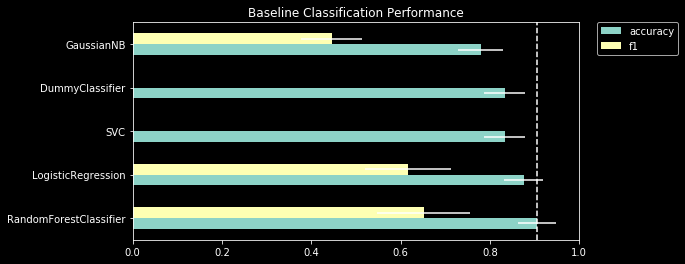

In [18]:
acc_plot = plot_results(bs_df, 'Baseline Classification Performance')
max_base_acc = bs_df['accuracy'].max()
acc_plot.axvline(max_base_acc, linestyle='--')

## Experiment 2: Effects of sampling
In this experiment we wanted to investigate weather or not oversampling the minority class label would improve our predictive capacity. In this dataset, the minority class is `stable` indicating that most binary compounds are not stable. We do not have any notion of the temperature or pressure dependence of this stability.


In order to address the class imbalance that exists we used a simple technique called over sampling. In our code, the minority and majority class labels are found. Then samples are drawn with replacement from the data labeled as a minority until the number of data points representing both classes are equal. We then evaluate models fit to this new dataset.

In [19]:
e2_data_path = os.path.join('..','results','oversample','sampled.csv')
e2_df = pd.read_csv(e2_data_path).drop(['Unnamed: 0'], axis=1).sort_values('accuracy', ascending=False)

In [20]:
e2_df

,type,data_size,accuracy,accuracy_std,f1,f1_std,recall,recall_std,precision,precision_std
2,RandomForestClassifier,871,0.979091,0.018341,0.938206,0.042102,0.889858,0.070859,0.994737,0.016644
1,SVC,871,0.975905,0.009440,0.914760,0.049059,0.846211,0.081161,1.000000,0.000000
3,LogisticRegression,871,0.925070,0.028751,0.761741,0.057793,0.713979,0.095999,0.829004,0.071843
4,DummyClassifier,871,0.832889,0.046796,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0,GaussianNB,871,0.806884,0.040829,0.468822,0.063121,0.527819,0.126278,0.477207,0.173177


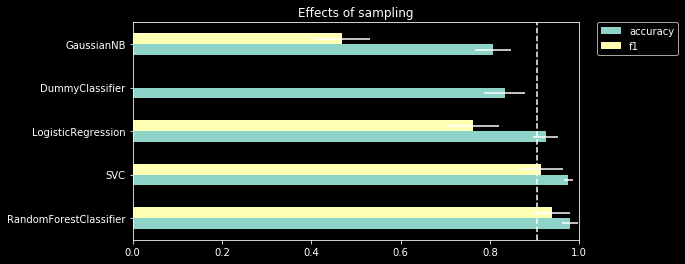

In [21]:
sampling_plot = plot_results(e2_df, 'Effects of sampling')
sampling_plot.axvline(max_base_acc, linestyle='--')

## Experiment 3: Impact of Feature Engineering
We propose the hypothesis that features which represent the energy of formation should improve model performance. This is because negative changes in energy of formation means a compound will be stable. To test this we added in cohesive energy features from Materials Project. We compared the standard "magpie" elemental features and stoichiometric norms against adding the cohesive energy of the binary compound and its elemental constituents. We explored all permutations of these features.
* `ele` Cohesive energy of formulaA and formulaB.
* `cmpd` Cohesive energy of an integer chemical formula created from the stability vector.
* `standard` Standard "magpie" elemental features and stoichiometric norms.

In [22]:
e3_data_path = os.path.join('..','results','features','features.csv')
e3_df = pd.read_csv(e3_data_path).sort_values('accuracy', ascending=False).rename({'Unnamed: 9': 'feature_set'}, axis=1)
e3_df['order'] = e3_df['feature_set'].map(feature_order_dict)
groups = e3_df.groupby('type')

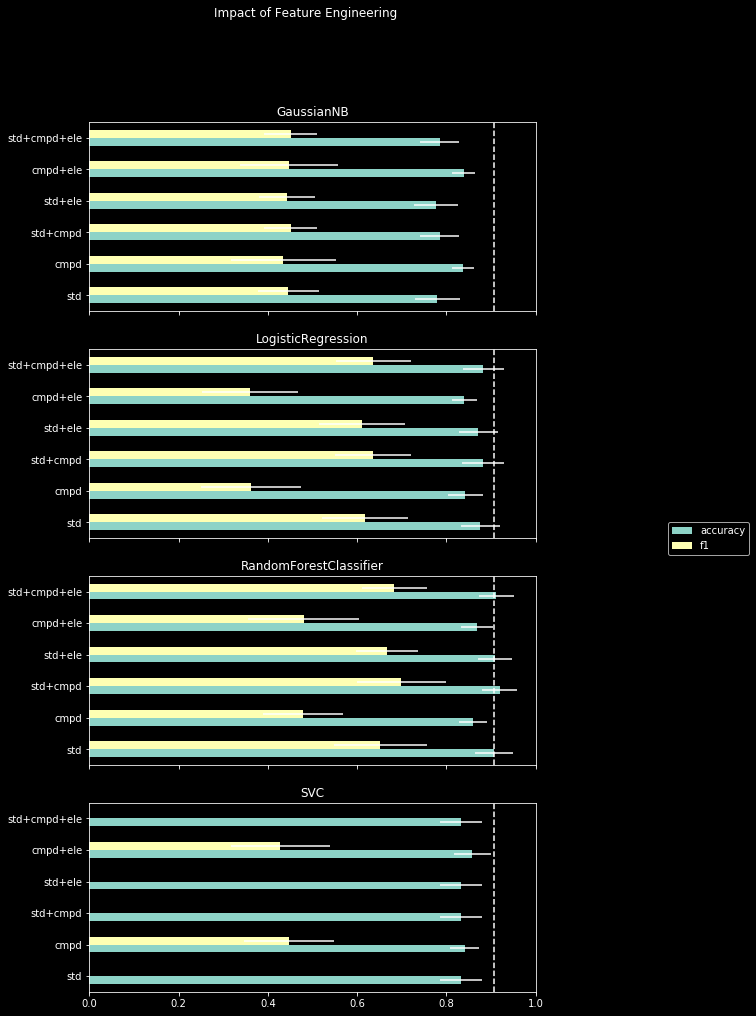

In [23]:
import numpy as np
fig,axs = plt.subplots(4,1, sharex=True, sharey=True, figsize=(8,16))
fig.suptitle('Impact of Feature Engineering')

for model, ax in zip(groups.groups, axs):
    data = groups.get_group(model)
    plot_feature_results(data, ax, model)
    ax.axvline(max_base_acc, linestyle='--')
    
plt.legend(loc = 'lower center', bbox_to_anchor = (0.7,0.5,1,1),
            bbox_transform = plt.gcf().transFigure )    

## Experiment 4: Dataset Size
The final and often hardest problem to address is the effect of the amount of training data. We perform a 'data ramp' which divides the training data into equal portions and then runs group k-folds on increasingly larger training data sets.

In [25]:
e4_data_path = os.path.join('..','results','data_ramp','fixed_amp.csv')
e4_df = pd.read_csv(e4_data_path).drop('Unnamed: 0', axis=1)
e4_df = e4_df[e4_df['type'] != 'DummyClassifier']
groups = e4_df.groupby('type')

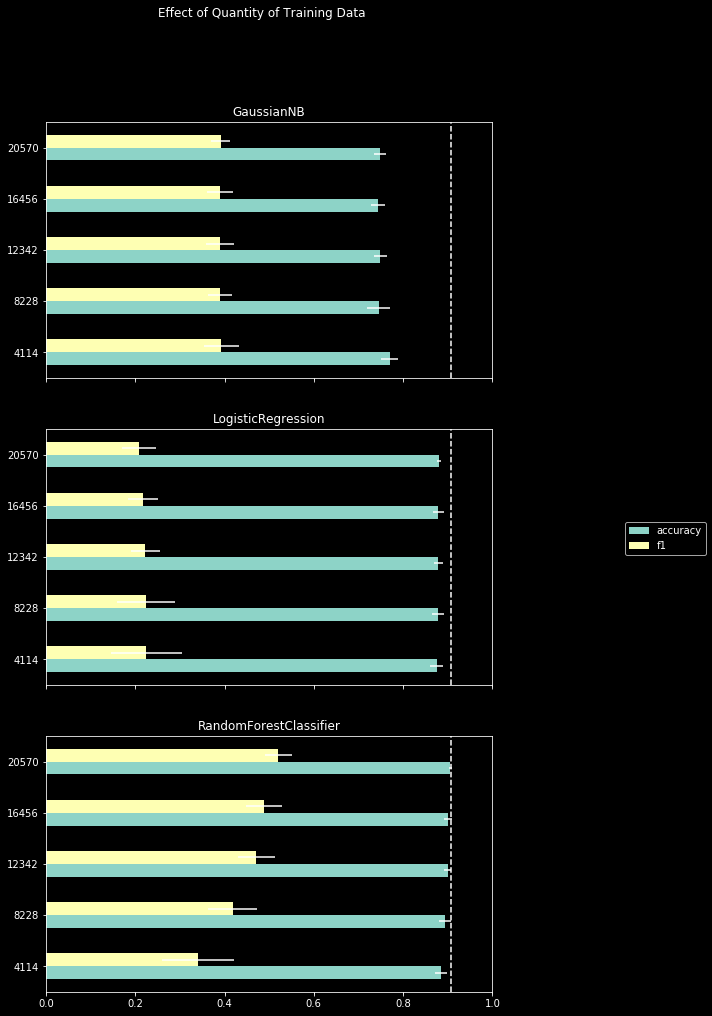

In [26]:
fig,axs = plt.subplots(3,1, sharex=True, sharey=True, figsize=(8,16))
fig.suptitle('Effect of Quantity of Training Data')

for model, ax in zip(groups.groups, axs):
    data = groups.get_group(model)
    plot_ramp_results(data, ax, model)
    ax.axvline(max_base_acc, linestyle='--')
    
plt.legend(loc = 'lower center', bbox_to_anchor = (0.7,0.5,1,1),
            bbox_transform = plt.gcf().transFigure )